In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import datetime, os
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import linalg as LA
import cv2
from tqdm import tqdm
from skimage.metrics import structural_similarity

In [2]:
df = pd.read_csv('./input/boneage-training-dataset.csv')

In [3]:
def get_dataset():
    #loading dataframes
    train_df = pd.read_csv('./input/boneage-training-dataset.csv')
    test_df = pd.read_csv('./input/boneage-test-dataset.csv')

    #appending file extension to id column for both training and testing dataframes
    train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
    test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 
    train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
    return train_df, test_df

In [4]:
train_df,_ = get_dataset()

In [5]:
train_df.head()

,id,boneage,male,gender
0,1377.png,180,False,female
1,1378.png,12,False,female
2,1379.png,94,False,female
3,1380.png,120,True,male
4,1381.png,82,False,female


In [6]:
def pre_processing(image, quantile):
    orginal_image = image.copy()
    gray_image  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.GaussianBlur(gray_image, (51, 51), 0)
    #plt.hist(gray_image.ravel(),256,[0,256]); plt.show()
    #gray_image = cv2.blur(gray_image,ksize=(5,5))
    gray_image = cv2.equalizeHist(gray_image)
    #plt.hist(gray_image.ravel(),256,[0,256]); plt.show()

    # applying the sharpening kernel to the image
    #sharpened = cv2.filter2D(gray_image, -1, kernel_sharpening)
    filtered_image = np.where(gray_image > np.quantile(gray_image, quantile), gray_image, 0)

    _,thresh = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

    # draw contours on the original image
    cv2.drawContours(image=orginal_image, contours=contours, contourIdx=-1, color=(255,0,0), thickness=5, lineType=cv2.LINE_AA)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    stencil = np.zeros(image.shape).astype(image.dtype)
    contours = np.array(sorted_contours[0:1],)
    color = [255, 255, 255]
    cv2.fillPoly(stencil, contours, color)
    result = cv2.bitwise_and(image, stencil)
    result = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
    #Create our shapening kernel, remember it must sum to one 
    #kernel_sharpening = np.array([[-1,-1,-1], 
    #                              [-1, 9,-1],
    #                              [-1,-1,-1]])
    # applying the sharpening kernel to the image
    #sharpened = cv2.filter2D(result, -1, kernel_sharpening)
    result = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 2) 
    #plt.imshow(result)
    #plt.show()
    return result

In [7]:
def find_similarities_then_select_best(first_gray, second_gray):
    # Compute SSIM between two images
    score, diff = structural_similarity(first_gray, second_gray, full=True)
    return score
    #print("Similarity Score: {:.3f}%".format(score * 100))

In [144]:
image = cv2.imread('./input/boneage-training-dataset/boneage-training-dataset/1378.png')

In [9]:
arr = np.arange(0.6, 0.9, 0.01)

In [10]:
arr

array([0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 ,
       0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81,
       0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 ])

In [95]:
best_image = None

std_scores = []
avg_scores = []

for quantile in arr[::-1]:
    base_image = pre_processing(image, quantile)
    sim_scores = []
    for idx in arr:
        if idx != quantile:  
            compare_to = pre_processing(image, idx)
            sim_score = find_similarities_then_select_best(base_image, compare_to)
            print(f"Base : {quantile} - Compare To : {idx} - Sim Score : {sim_score}")
            sim_scores.append(sim_score)
    print(f"Sim scores avg : {sum(sim_scores) / len(sim_scores)} --- Std : {np.std(sim_scores)}")
    p1 = sum(sim_scores) / len(sim_scores)
    p2 = np.std(sim_scores)
    avg_scores.append(p1)
    std_scores.append(p2)
    #print(f"My score = { (p1 * 100) / ((mx - mn)*p2)}")
    print("*******************************************************")

Base : 0.9000000000000002 - Compare To : 0.6 - Sim Score : 0.7628414556852504
Base : 0.9000000000000002 - Compare To : 0.61 - Sim Score : 0.7628414556852504
Base : 0.9000000000000002 - Compare To : 0.62 - Sim Score : 0.7628414556852504
Base : 0.9000000000000002 - Compare To : 0.63 - Sim Score : 0.7677960184918567
Base : 0.9000000000000002 - Compare To : 0.64 - Sim Score : 0.7677960184918567
Base : 0.9000000000000002 - Compare To : 0.65 - Sim Score : 0.781810630434565
Base : 0.9000000000000002 - Compare To : 0.66 - Sim Score : 0.7823661694117046
Base : 0.9000000000000002 - Compare To : 0.67 - Sim Score : 0.7823661694117046
Base : 0.9000000000000002 - Compare To : 0.68 - Sim Score : 0.7828443635568625


KeyboardInterrupt: 

In [145]:
orginal_image = image.copy()
gray_image  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image = cv2.GaussianBlur(gray_image, (51, 51), 0)
_,thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
filtered_image = np.where(gray_image > np.quantile(gray_image, 0.6), gray_image, 0)
contours, hierarchy = cv2.findContours(image=filtered_image, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image=orginal_image, contours=contours, contourIdx=-1, color=(255,0,0), thickness=5, lineType=cv2.LINE_AA)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
stencil = np.zeros(image.shape).astype(image.dtype)
contours = np.array(sorted_contours[0:1],)
color = [255, 255, 255]
cv2.fillPoly(stencil, contours, color)
result = cv2.bitwise_and(orginal_image, stencil)
result = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
#Create our shapening kernel, remember it must sum to one 
#kernel_sharpening = np.array([[-1,-1,-1], 
#                              [-1, 9,-1],
#                              [-1,-1,-1]])
# applying the sharpening kernel to the image
#sharpened = cv2.filter2D(result, -1, kernel_sharpening)
brightness = np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
if brightness > 80:
    result = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 2)
    print("light")
elif brightness > 35 and brightness < 80:
    result = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 3)
    print("normal")
else:
    result = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 4)
    print("dark")

light


In [146]:
np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

143.4106716309875

In [158]:
result = cv2.adaptiveThreshold(result, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 5)

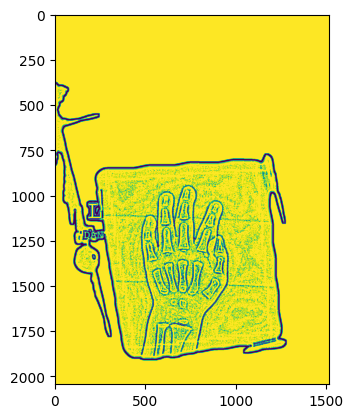

202098


In [159]:
plt.imshow(result)
plt.show()
print((result-255).sum())
a = (result-255).sum()

In [151]:
sim_score_list = []
pixel_diff_list = []
my_score_list = []


for idx, quantile in enumerate(arr):
    base_image = pre_processing(image, quantile)
    sim_score = find_similarities_then_select_best(base_image, result)
    sim_score_list.append(sim_score * 100)
    pixel_diff_list.append(int(a) - int((base_image-255).sum()))
    my_score_list.append((sim_score * 100) / abs(int(a) - int((base_image-255).sum())))
    print(f"Sim_score : {sim_score} -- Quantile : {quantile:.2f} -- Pixel Diff : {pixel_diff_list[idx]} -- My Score : {my_score_list[idx]}")

Sim_score : 0.9772401873926757 -- Quantile : 0.60 -- Pixel Diff : 2190 -- My Score : 0.04462283960697149
Sim_score : 0.9772401873926757 -- Quantile : 0.61 -- Pixel Diff : 2190 -- My Score : 0.04462283960697149
Sim_score : 0.9772401873926757 -- Quantile : 0.62 -- Pixel Diff : 2190 -- My Score : 0.04462283960697149
Sim_score : 0.9772401873926757 -- Quantile : 0.63 -- Pixel Diff : 2190 -- My Score : 0.04462283960697149
Sim_score : 0.9772401873926757 -- Quantile : 0.64 -- Pixel Diff : 2190 -- My Score : 0.04462283960697149
Sim_score : 0.9772401873926757 -- Quantile : 0.65 -- Pixel Diff : 2190 -- My Score : 0.04462283960697149
Sim_score : 0.9772401873926757 -- Quantile : 0.66 -- Pixel Diff : 2190 -- My Score : 0.04462283960697149
Sim_score : 0.9485137415970627 -- Quantile : 0.67 -- Pixel Diff : 40301 -- My Score : 0.002353573711811277
Sim_score : 0.9485137415970627 -- Quantile : 0.68 -- Pixel Diff : 40301 -- My Score : 0.002353573711811277
Sim_score : 0.9385151776136331 -- Quantile : 0.69 -

In [92]:
top_5_sim_score_idx

array([0, 1, 2, 3, 4])

In [113]:
top_5_pixel_diff_idx

array([0, 1, 2, 3, 4])

In [103]:
if len(common) == 0:
    top_5_my_score_list_idx = np.array(my_score_list).argsort()[-5:][::-1]
    max_my_score_index = top_5_my_score_list_idx[0]

In [104]:
max_my_score_index

0

In [105]:
arr[max_my_score_index]

0.6

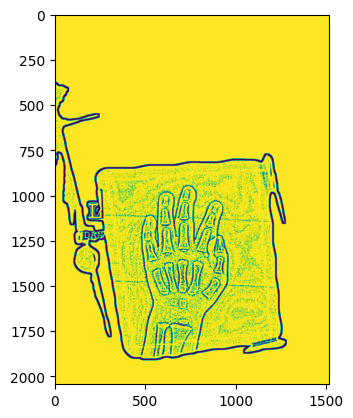

202098
199928
Diff : 2170
Quantile : 0.6


In [160]:
max_my_score_index = None
top_5_sim_score_idx = np.array(sim_score_list).argsort()[-5:][::-1]
top_5_pixel_diff_idx = np.array([abs(ele) for ele in pixel_diff_list]).argsort()[:5]
common = list(set(top_5_pixel_diff_idx).intersection(top_5_sim_score_idx))
if len(common) == 0:
    top_5_my_score_list_idx = np.array(my_score_list).argsort()[-5:][::-1]
    max_my_score_index = top_5_my_score_list_idx[0]
else:
    max_my_score_index = my_score_list.index(np.array(my_score_list)[common].max())
b = pre_processing(image, arr[max_my_score_index])
plt.imshow(b)
plt.show()
print(a)
print((b-255).sum())
print(f"Diff : {abs(int((b-255).sum()) - int(a))}")
print(f"Quantile : {arr[max_my_score_index]}")

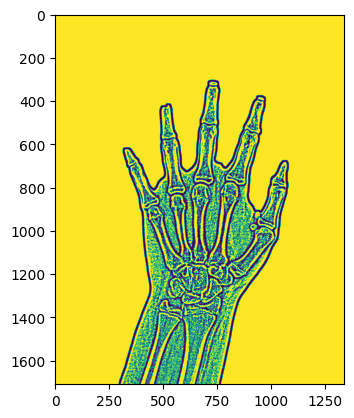

In [46]:
b = pre_processing(image, 0.1)
plt.imshow(b)
plt.show()

In [55]:
top_5_sim_score_idx

array([ 0,  1, 10,  9, 11])

In [56]:
top_5_pixel_diff_idx

array([10, 11,  9, 12,  8])

In [68]:
common = list(set(top_5_pixel_diff_idx).intersection(top_5_sim_score_idx))

In [73]:
max_my_score_index = my_score_list.index(np.array(my_score_list)[common].max())

In [74]:
max_my_score_index

10

In [75]:
print(f"Quantile : {arr[max_my_score_index]}")

Quantile : 0.7000000000000001


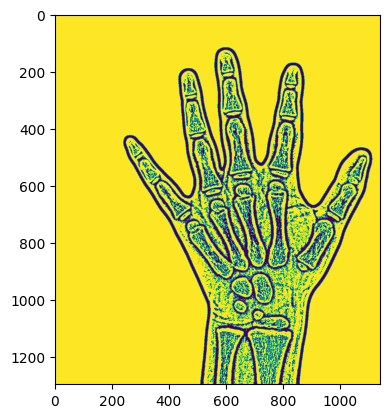

190256
200390
10134


In [18]:
b = pre_processing(image, 0.68)
plt.imshow(b)
plt.show()
print(a)
print((b-255).sum())
print(abs(int((b-255).sum()) - int(a)))

In [369]:
26127555 > 25533150

True

In [34]:
std_scores

[0.05438313097536593,
 0.02809263027983254,
 0.05294478066179553,
 0.06680939598399536]

In [35]:
avg_scores

[0.8397636219789387,
 0.8792822893379686,
 0.8814895840551967,
 0.8600189881939776]

In [24]:
my_score = (10 / np.array(std_scores) * np.array(avg_scores)) / (np.array(std_scores) + np.array(avg_scores))

In [25]:
my_score

array([23388.67078226, 19297.99718879, 71738.52057574, 21312.99810241])

In [26]:
index = list(my_score).index(max(list(my_score)))

In [27]:
index

2

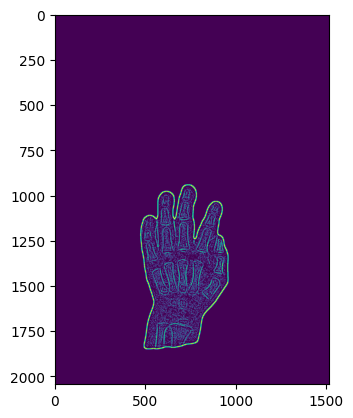

In [32]:
best_image = pre_processing(image, 0.89) - 255
plt.imshow(best_image)
plt.show()

In [ ]:
for filename, boneage in (list(train_df[['id','boneage']].values)):
    print(filename)
    fname = './input/boneage-training-dataset/boneage-training-dataset/'+ filename
    image = cv2.imread(fname)
    best_image = None

    std_scores = []
    avg_scores = []

    for quantile in arr[::-1]:
        base_image = pre_processing(image, quantile)
        sim_scores = []
        for idx in arr:
            if idx != quantile:  
                compare_to = pre_processing(image, idx)
                sim_score = find_similarities_then_select_best(base_image, compare_to)
                #print(f"Base : {quantile} - Compare To : {idx} - Sim Score : {sim_score}")
                sim_scores.append(sim_score)
        #print(f"Sim scores avg : {sum(sim_scores) / len(sim_scores)} --- Std : {np.std(sim_scores)}")
        p1 = sum(sim_scores) / len(sim_scores)
        p2 = np.std(sim_scores)
        avg_scores.append(p1)
        std_scores.append(p2)
        #print(f"My score = { (p1 * 100) / ((mx - mn)*p2)}")
        #print("*******************************************************")
    my_score = (10 / np.array(std_scores) * np.array(avg_scores)) / (np.array(std_scores) + np.array(avg_scores))
    index = list(my_score).index(max(list(my_score)))
    print(arr[::-1][index])
    best_image = pre_processing(image, arr[::-1][index]) - 255
    plt.imshow(best_image)
    plt.show()
    result = cv2.normalize(best_image, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    cv2.imwrite(f'/tf/bone_age/new_dataset/{filename}', cv2.resize(result, (256, 256), interpolation=cv2.INTER_CUBIC)) 

In [11]:
best_image = None

std_scores = []
avg_scores = []

for quantile in arr[::-1]:
    base_image = pre_processing(image, quantile)
    sim_scores = []
    for idx in arr:
        if idx != quantile:  
            compare_to = pre_processing(image, idx)
            sim_score = find_similarities_then_select_best(base_image, compare_to)
            print(f"Base : {quantile} - Compare To : {idx} - Sim Score : {sim_score}")
            sim_scores.append(sim_score)
    print(f"Sim scores avg : {sum(sim_scores) / len(sim_scores)} --- Std : {np.std(sim_scores)}")
    p1 = sum(sim_scores) / len(sim_scores)
    p2 = np.std(sim_scores)
    avg_scores.append(p1)
    std_scores.append(p2)
    #print(f"My score = { (p1 * 100) / ((mx - mn)*p2)}")
    print("*******************************************************")

NameError: name 'find_similarities_then_select_best' is not defined

In [ ]:
sum_of_images = []
for quantile in arr:
    base_image = pre_processing(image, quantile) - 255
    plt.imshow(base_image)
    plt.show()

In [ ]:
arr = np.arange(0.59, 0.89, 0.1)
for filename, boneage in (list(train_df[['id','boneage']].values)):
    print(filename)
    fname = './input/boneage-training-dataset/boneage-training-dataset/'+ filename
    image = cv2.imread(fname)
    sum_of_images = []
    for quantile in arr:
        base_image = pre_processing(image, quantile) - 255
        sum_of_images.append(base_image.sum())
        print(base_image.sum())
    index = None
    diff = []
    for val in range(len(sum_of_images) - 1):
        diff.append(sum_of_images[val] - sum_of_images[val + 1])
        
    for val in range(len(diff) - 2):
        if abs((diff[val + 1]) - int(diff[val]))> 35000 and abs((diff[val + 1]) - int(diff[val]))<50000:
            index = (val + 1)

        if abs((diff[val + 2]) - int(diff[val + 1])) > 35000 and abs((diff[val + 2]) - int(diff[val + 1])) < 70000:
            index = (val + 2)

        if abs((diff[val + 2]) - int(diff[val + 1])) < 5000:
            index = len(diff)
            
    if index != None:
        best_image_candidate = pre_processing(image, arr[index]) - 255
        plt.imshow(best_image_candidate)
        plt.show()
        result = cv2.normalize(best_image_candidate, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        cv2.imwrite(f'/tf/bone_age/new_dataset/{filename}', cv2.resize(result, (256, 256), interpolation=cv2.INTER_CUBIC))    # mention the path you want to save the result



In [ ]:
std_scores

In [ ]:
avg_scores

In [ ]:
my_score = (10 / np.array(std_scores) * np.array(avg_scores)) / (np.array(std_scores) + np.array(avg_scores))

In [ ]:
my_score

In [ ]:
np.mean(my_score)

In [ ]:
index = list(my_score).index(max(list(my_score)))

In [ ]:
index

In [ ]:
arr[::-1][index]

In [ ]:
ptr = sum(std_scores) / len(std_scores)
low_std_score_indexes=[std for std,idx in enumerate(list(map(lambda x:x if ptr < x else None, std_scores))) if idx != None]

In [ ]:
ptr

In [ ]:
low_std_score_indexes

In [ ]:
def get_best(low_std_score_indexes,avg_scores):
    index_of_best = 0
    best_score = 0
    for idx in low_std_score_indexes:
        if best_score < avg_scores[idx]:
            index_of_best = idx
            best_score = avg_scores[idx]
            
    return index_of_best

In [ ]:
print(get_best(low_std_score_indexes ,avg_scores ))

In [ ]:
arr

In [ ]:
best_image = pre_processing(image, 0.7899999999999999)
plt.imshow(best_image)
plt.show()

In [ ]:
best_image = pre_processing(image, 0.6)
plt.imshow(best_image)
plt.show()

In [ ]:
def find_similarities_then_select_best(first_gray, second_gray):
    # Compute SSIM between two images
    score, diff = structural_similarity(first_gray, second_gray, full=True)
    return score
    #print("Similarity Score: {:.3f}%".format(score * 100))

In [ ]:
orginal_image = image.copy()

In [ ]:
gray_image  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#gray_image = cv2.GaussianBlur(gray_image, (7, 7), 0)
gray_image = cv2.medianBlur(gray_image,5)


In [ ]:

plt.imshow(gray_image)
plt.show()

In [ ]:
filtered_image = np.where(gray_image > np.quantile(gray_image, 0.7), gray_image, 0)

In [ ]:
thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 2) 

In [ ]:
ret, thresh = cv2.threshold(filtered_image,0, 255, cv2.THRESH_BINARY)

In [ ]:
plt.imshow(thresh)
plt.show()

In [ ]:
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                     
# draw contours on the original image
cv2.drawContours(image=orginal_image, contours=contours, contourIdx=-1, color=(255,0,0), thickness=5, lineType=cv2.LINE_AA)

In [ ]:
plt.imshow(orginal_image)
plt.show()

In [ ]:
len(contours)

In [ ]:
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

In [ ]:
cv2.drawContours(gray_image, [sorted_contours[0]], -1, 255, 3)

In [ ]:
plt.imshow(gray_image)
plt.show()

In [ ]:
cv2.drawContours(image, [sorted_contours[0]], -1, 255, 3)

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
stencil = np.zeros(image.shape).astype(image.dtype)

In [ ]:
sorted_contours[0:5]

In [ ]:
color = [255, 255, 255]
cv2.fillPoly(stencil, sorted_contours[0], color)
result = cv2.bitwise_and(image, stencil)
plt.imshow(result)
plt.show()

In [ ]:
img = cv2.imread("./input/boneage-training-dataset/boneage-training-dataset/1492.png")
stencil = np.zeros(img.shape).astype(img.dtype)
contours = sorted_contours[0:1]
color = [255, 255, 255]
cv2.fillPoly(stencil, contours, color)
result = cv2.bitwise_and(img, stencil)
plt.imshow(result)
plt.show()